# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: 7
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [2]:
column_list = ['paper_id'] + ['word_attributes_' + str(i) for i in range(1433)] + ['class_label']
pd_content = pd.read_csv('data/cora/cora.content', sep='\t', header=None, names=column_list)
pd_content.head()

,paper_id,word_attributes_0,word_attributes_1,word_attributes_2,word_attributes_3,word_attributes_4,word_attributes_5,word_attributes_6,word_attributes_7,word_attributes_8,...,word_attributes_1424,word_attributes_1425,word_attributes_1426,word_attributes_1427,word_attributes_1428,word_attributes_1429,word_attributes_1430,word_attributes_1431,word_attributes_1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [3]:
pd_content['class_label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [4]:
my_field = 'Theory'
features = pd_content[pd_content['class_label'] == 'Theory'].iloc[:, 1:-1].values
features.shape

(351, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [5]:
distance = np.sum(features**2, axis=1) + np.sum(features**2, axis=1)[:, np.newaxis] - 2 * np.dot(features, features.T)
distance = np.sqrt(distance)
distance.shape

(351, 351)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.748216300560453

Plot an histogram of the euclidean distances.

Text(0, 0.5, 'Count')

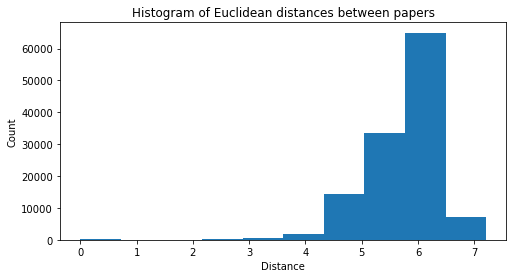

In [7]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());
plt.xlabel('Distance')
plt.ylabel('Count')

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = distance.copy()
A_feature[A_feature < mean_distance] = 1
A_feature[A_feature >= mean_distance] = 0
# because the previous code will change the value of diagonal elements into 1
# i change it back to 0 here
np.fill_diagonal(A_feature, 0)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [9]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

num_paper = pd_content.shape[0]
A_citation = np.zeros((num_paper, num_paper))
for entry in cora_cites:
    # get the orignal paper_id and find the new reseted index
    cited_id = pd.Index(pd_content['paper_id']).get_loc(int(entry[0]))
    citing_id = pd.Index(pd_content['paper_id']).get_loc(int(entry[1]))
    A_citation[cited_id][citing_id] = 1
    A_citation[citing_id][cited_id] = 1
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [10]:
field_ids = pd_content[pd_content['class_label'] == 'Theory']['paper_id']
field_ids = field_ids.reset_index().rename(columns={'index': 'old_index'})
num_field_paper = field_ids.shape[0]
A_citation = np.zeros((num_field_paper, num_field_paper))

for entry in cora_cites:
    # only count when both papers are Theory paper
    if int(entry[0]) not in field_ids['paper_id'].values or int(entry[1]) not in field_ids['paper_id'].values:
        continue
    cited_id = pd.Index(field_ids['paper_id']).get_loc(int(entry[0]))
    citing_id = pd.Index(field_ids['paper_id']).get_loc(int(entry[1]))
    A_citation[cited_id][citing_id] = 1
    A_citation[citing_id][cited_id] = 1
A_citation.shape

(351, 351)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [11]:
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [12]:
A_citation.shape

(351, 351)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [13]:
num_edges_feature = A_feature.sum() / 2
num_edges_citation = A_citation.sum() / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 25321.0
Number of edges in the citation graph: 534.0


Plot the degree distribution histogram for each of the graphs.

Text(0, 0.5, 'Frequency')

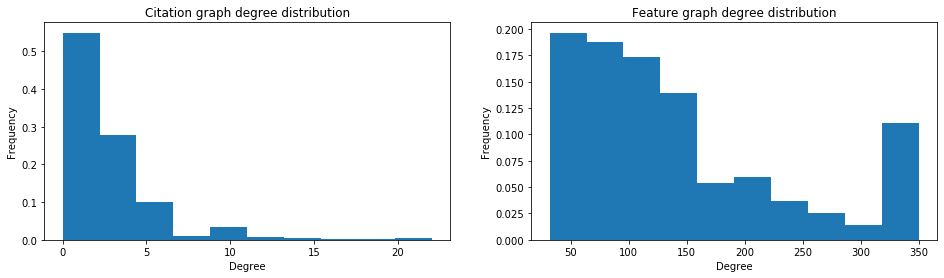

In [14]:
# degree is the number of edges a node has which is the sum of the entire row in the adjacency matrix
degrees_citation = A_citation.sum(axis=1)
degrees_feature = A_feature.sum(axis=1)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')

Calculate the first and second moments of the degree distribution of each graph.

In [15]:
cit_moment_1 = degrees_citation.mean()
cit_moment_2 = (degrees_citation**2).mean()

feat_moment_1 = degrees_feature.mean()
feat_moment_2 = (degrees_feature**2).mean()

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.0427350427350426
2nd moment of citation graph: 18.165242165242166
1st moment of feature graph: 144.27920227920228
2nd moment of feature graph: 29639.094017094016


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

```
Looking at the 1st moment, we can see that the citation graph has a smaller value, which means the average degree of it is smaller than the feature graph. This is quite reasonable beacause there must be a lot of similar words used in the paper.

As for the 2nd moment, we can see that the feature graph has a larger value, which indicates that it has a larger variance. We can observe this by looking at the degree distribution, the distribution of feature graph is clearly "wider" than the citation graph
```

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

In [16]:
indices_of_big_hubs_f = np.argsort(degrees_feature)[-20:]
indices_of_big_hubs_f

array([272, 289, 293, 151, 298, 224,  72, 327, 305, 349,  65, 264, 311,
       105, 177, 122, 124, 145,  69,  75])

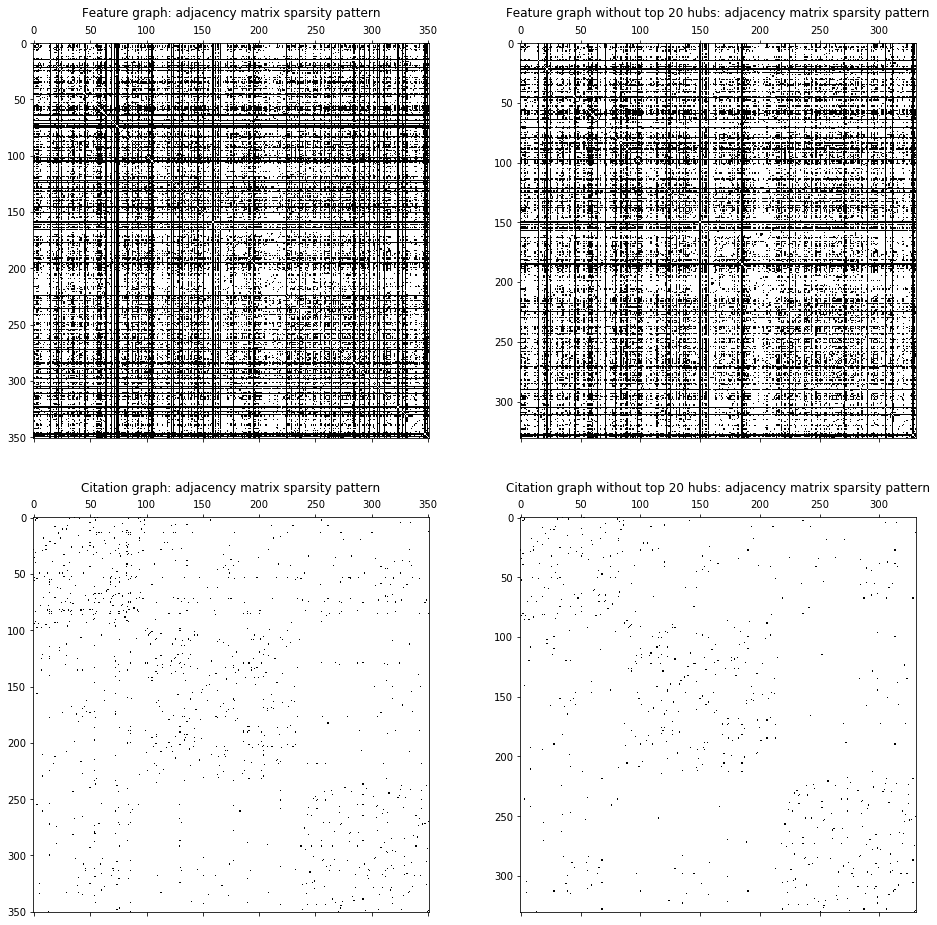

In [17]:
indices_of_big_hubs_f = np.argsort(degrees_feature)[-20:]
indices_of_big_hubs_c = np.argsort(degrees_citation)[-20:]
reduced_A_feature = np.delete(A_feature, indices_of_big_hubs_f, axis=0)
reduced_A_feature = np.delete(reduced_A_feature, indices_of_big_hubs_f, axis=1)
reduced_A_citation = np.delete(A_citation, indices_of_big_hubs_c, axis=0)
reduced_A_citation = np.delete(reduced_A_citation, indices_of_big_hubs_c, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

Text(0, 0.5, 'Frequency')

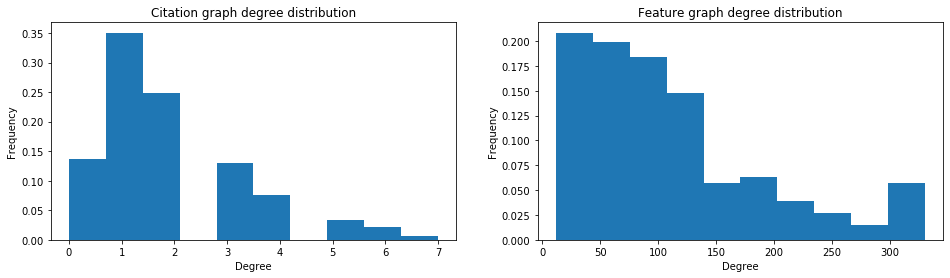

In [18]:
reduced_degrees_feat = reduced_A_feature.sum(axis=1)
reduced_degrees_cit = reduced_A_citation.sum(axis=1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')

Compute the first and second moments for the new graphs.

In [19]:
reduced_cit_moment_1 = reduced_degrees_cit.mean()
reduced_cit_moment_2 = (reduced_degrees_cit**2).mean()

reduced_feat_moment_1 = reduced_degrees_feat.mean()
reduced_feat_moment_2 = (reduced_degrees_feat**2).mean()


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.8731117824773413
Citation graph second moment: 5.6072507552870094
Feature graph first moment:  111.8489425981873
Feature graph second moment:  19154.205438066467


Print the number of edges in the reduced graphs.

In [20]:
num_edges_reduced_feature = reduced_A_feature.sum() / 2
num_edges_reduced_citation = reduced_A_citation.sum() / 2
print(f"Number of edges in the feature graph: {num_edges_reduced_feature}")
print(f"Number of edges in the citation graph: {num_edges_reduced_citation}")

Number of edges in the feature graph: 18511.0
Number of edges in the citation graph: 310.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

In [21]:
per_change_cit_moment_1 = (cit_moment_1 - reduced_cit_moment_1) / cit_moment_1
per_change_cit_moment_2 = (cit_moment_2 - reduced_cit_moment_2) / cit_moment_2
per_change_feat_moment_1 = (feat_moment_1 - reduced_feat_moment_1) / feat_moment_1
per_change_feat_moment_2 = (feat_moment_2 - reduced_feat_moment_2) / feat_moment_2

print("Percentage changes for citation graph first moment {:.2f}%".format(per_change_cit_moment_1 * 100))
print("Percentage changes for citation graph second moment {:.2f}%".format(per_change_cit_moment_2 * 100))
print("Percentage changes for feature graph first moment {:.2f}%".format(per_change_feat_moment_1 * 100))
print("Percentage changes for feature graph second moment {:.2f}%".format(per_change_feat_moment_2 * 100))

Percentage changes for citation graph first moment 38.44%
Percentage changes for citation graph second moment 69.13%
Percentage changes for feature graph first moment 22.48%
Percentage changes for feature graph second moment 35.38%


**Your answer here:**

```
No, the citation graph is affected more greatly. The second moment of the citation graph is affected the most, because it remove almost all of the large degree nodes (degree > 10) and therefore reduce the variance.
```

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [22]:
# i find this threshold by trying several ones
threshold = 3.61

A_feature_pruned = distance.copy()
A_feature_pruned[A_feature_pruned < threshold] = 1
A_feature_pruned[A_feature_pruned >= threshold] = 0
np.fill_diagonal(A_feature_pruned, 0)

num_edges_feature_pruned = A_feature_pruned.sum() / 2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 25321.0
Number of edges in the feature graph after pruning: 578.0
Number of edges in the citation graph: 534.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

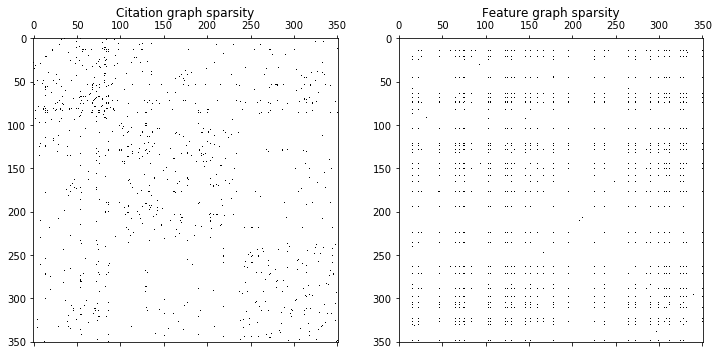

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [24]:
# the nth power of the adjacency matrix gives the number of paths of length n from vertex i to vertex j
# so to get the path matrix, we can simply sum up the power of the adjacency matrix
path_matrix_citation = np.zeros(A_citation.shape)
for i in range(10):
    path_matrix_citation += np.linalg.matrix_power(A_citation, i + 1)
path_matrix_feature = np.zeros(A_feature.shape)
for i in range(10):
    path_matrix_feature += np.linalg.matrix_power(A_feature, i + 1)

Check the sparsity pattern for both of path matrices.

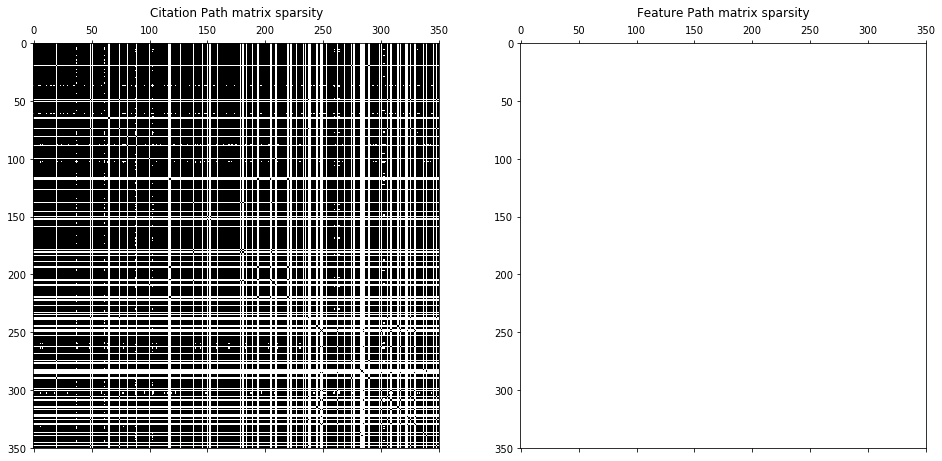

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

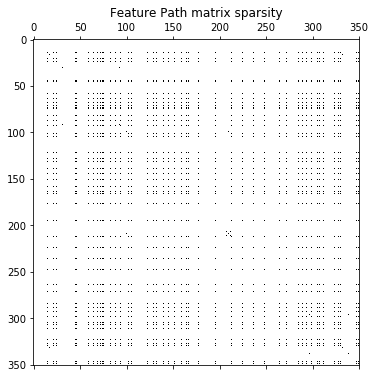

In [26]:
path_matrix_pruned = np.zeros(A_feature_pruned.shape)
for i in range(10):
    path_matrix_pruned += np.linalg.matrix_power(A_feature_pruned, i + 1)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

```
Yes, there are differences. The path matrix of the original feature graph has no zero in it, so there is no empty spot in the sparsity plot. But there are plenty of empty spots in the sparsity plot of the path matrix of the pruned feature graph for N = 10, which means the pruned feature graph has quite a few not connected nodes.
```

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

```
if there is a path between every pair of nodes, then the graph is connected. I can check the path matrix and see if there are any zeros in it.

The path matrix of the original feature graph has no zero, so it is connected. (The code to evaluate this is down this cell)
```

In [27]:
# check if the number of nonzero elements equals to the number of all element
np.count_nonzero(path_matrix_feature) == path_matrix_feature.shape[0] * path_matrix_feature.shape[1]

True

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

```
I can check the value of N when I'm increasing N and see if there are any zeros in the path matrix.
```

If any of your graphs is connected, calculate the diameter using that process.

In [28]:
path_matrix_feature = A_feature.copy()
for i in range(10):
    if np.count_nonzero(path_matrix_feature) == path_matrix_feature.shape[0] * path_matrix_feature.shape[1]:
        diameter = i + 1
        break
    path_matrix_feature += np.matmul(path_matrix_feature, A_feature)

print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [29]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


```
Yes, my guess is the same as the one we get from NetworkX.
```

## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [30]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [31]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 351, Number of edges: 534
Number of self-loops: 0, Number of connected components: 36


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [32]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 351, Number of edges: 578
Number of self-loops: 0, Number of connected components: 299


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [33]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

351

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [34]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

556.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

```
The probability of a random network is the average degree (2m / n) divided by (N - 1), so that's how I do it.
```

In [35]:
p = (2 * m / n) / (n - 1)
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [36]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 541 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

```
Since the average degree of Barabási-Albert graphs is equal to 2m, we'll decide m, the preferential attachment as average degree divided by 2.
```

In [37]:
q = int(np.round((2 * m / n) / 2))
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [38]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 698 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [39]:
citation_component = sorted(nx.connected_component_subgraphs(G_citation), key=len, reverse=True)
giant_citation = citation_component[0]
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 287 nodes and 499 edges.


In [40]:
feature_component = sorted(nx.connected_component_subgraphs(G_feature), key=len, reverse=True)
giant_feature = feature_component[0]
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 48 nodes and 573 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [41]:
er_component = sorted(nx.connected_component_subgraphs(G_er), key=len, reverse=True)
giant_er = er_component[0]
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 331 nodes and 540 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

```
Since we have the fraction of giant component of the feature graph, we can use it to calculate the average degree based on the following foumula
```
![equation](https://latex.codecogs.com/gif.latex?S%20%3D%201%20-%20e%5E%7B-%5Cleft%20%5Clangle%20k%20%5Cright%20%5Crangle%20S%7D)

```
Then, we'll divide it by the number of nodes to get the new probability.
```

In [42]:
fraction_of_gc = giant_feature.number_of_nodes() / n
avg_degree = -1 * np.log(1 - fraction_of_gc) / fraction_of_gc

In [43]:
p_new = avg_degree / n
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [44]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
er_new_component = sorted(nx.connected_component_subgraphs(G_er_new), key=len, reverse=True)
giant_er_new = er_new_component[0]
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 162 edges.
The giant component of the new Erdos-Rényi network has 27 nodes and 26 edges.


```
The number of nodes in the giant component is now closer to the one the feature graph has.
```

### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

Text(0, 0.5, 'Frequency')

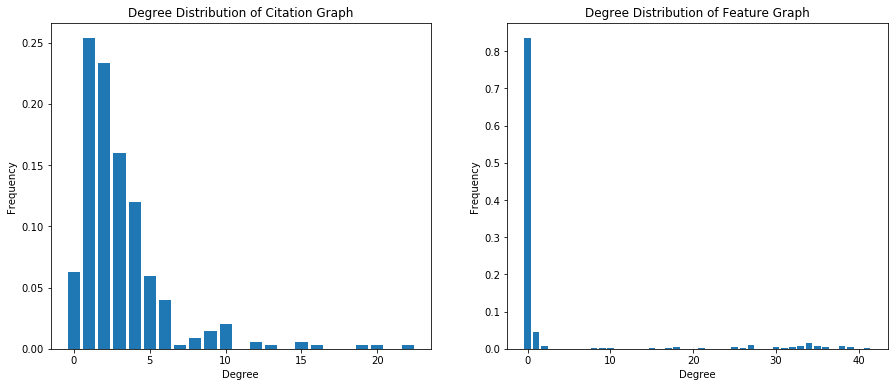

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Degree Distribution of Citation Graph')
citation_degrees = sorted([d for n, d in G_citation.degree])
deg, cnt = np.unique(citation_degrees, return_counts=True)
axes[0].bar(deg, cnt / sum(cnt));
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Degree Distribution of Feature Graph')
feature_degrees = sorted([d for n, d in G_feature.degree])
deg, cnt = np.unique(feature_degrees, return_counts=True)
axes[1].bar(deg, cnt / sum(cnt));
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

```
Yes, i'd say that their degree distributions are similar to a scale-free network with the citation graph having greater gamma value.
```

Now, plot the degree distribution historgrams for the simulated networks.

Text(0, 0.5, 'Frequency')

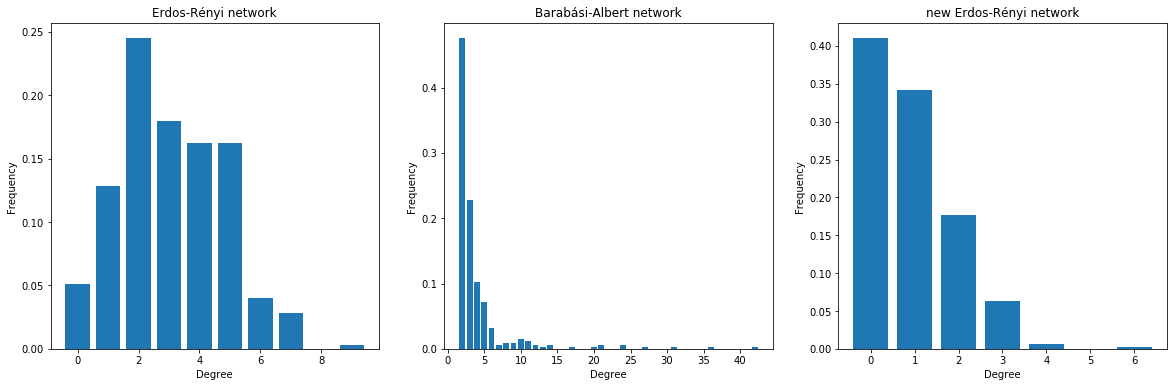

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = sorted([d for n, d in G_er.degree])
deg, cnt = np.unique(er_degrees, return_counts=True)
axes[0].bar(deg, cnt / sum(cnt));
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')


axes[1].set_title('Barabási-Albert network')
ba_degrees = sorted([d for n, d in G_ba.degree])
deg, cnt = np.unique(ba_degrees, return_counts=True)
axes[1].bar(deg, cnt / sum(cnt));
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')

axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = sorted([d for n, d in G_er_new.degree])
deg, cnt = np.unique(er_new_degrees, return_counts=True)
axes[2].bar(deg, cnt / sum(cnt));
axes[2].set_xlabel('Degree')
axes[2].set_ylabel('Frequency')

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

```
Yes, the Barabási-Albert network seems like a good match for the feature graphs.

And for the citation graph, the Barabási-Albert network seems like a better match if we look at the entire distribution.
```

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [47]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 351 nodes and 578 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

```
No, they are not the same. We can check whether the adjacency matrix of both models are equal or not.
```

In [48]:
np.array_equal(nx.adjacency_matrix(G_feature).todense(), nx.adjacency_matrix(G_config).todense())

False

```
They don't have the same adjacency matrix, so they are not the same graph. They just have the same statistics properties.
```

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [49]:
nx.average_clustering(G_citation)

0.19443820911432255

In [50]:
nx.average_clustering(G_feature)

0.10398745129734163

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

```
Clustering coefficient implies how closely linked between a node and it's neighbors. So the relationship between a node's neighbors of the citation graph is stronger than the feature graph.
```

Now, let us check the average clustering coefficient for the simulated networks.

In [51]:
nx.average_clustering(G_er)

0.0046805046805046815

In [52]:
nx.average_clustering(G_ba)

0.059321548467532514

In [53]:
nx.average_clustering(nx.Graph(G_config))

0.06097707013933905

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

```
No, the values are all too small compared to the values of citation graph and feature graph.
```

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

```
I found the powerlaw cluster network could be a beeter match in terms of degree distribution and clustering coefficient. Because according to the document of it, it is essentially a Barabási–Albert (BA) growth model which is already a good match in terms of degree distribution. Also, it can approximate average clustering. We can let it approximate the average of the average clustering coefficient of citation graph and feature graph.
```

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [54]:
G_plc = nx.powerlaw_cluster_graph(n, int(np.round((2 * m / n) / 2)), (nx.average_clustering(G_citation) + nx.average_clustering(G_feature)) / 2)

In [55]:
print('My powerlaw cluster network that simulates the citation graph has {} edges.'.format(G_plc.size()))

My powerlaw cluster network that simulates the citation graph has 698 edges.


In [56]:
print('The average clustering coefficient of my powerlaw cluster network is {}.'.format(nx.average_clustering(G_plc)))

The average clustering coefficient of my powerlaw cluster network is 0.1768820379780074.


Text(0, 0.5, 'Frequency')

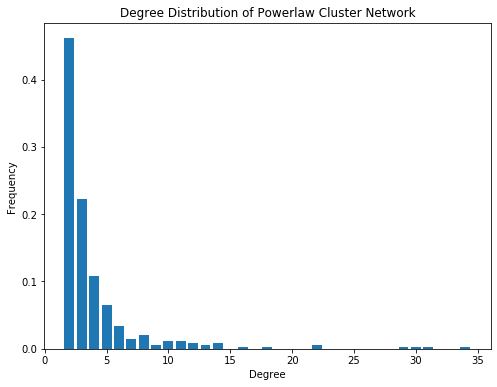

In [57]:
plc_degrees = sorted([d for n, d in G_plc.degree])
deg, cnt = np.unique(plc_degrees, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt / sum(cnt));
plt.title('Degree Distribution of Powerlaw Cluster Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')

Comment on the similarities of your match.

**Your answer here:**

```
The result meets my expectation. The number of edges, the average clustering coefficient and the degree distribution are a nice match to the citation graph and feature graph.
```